<a href="https://colab.research.google.com/github/rjenez/W266-final-project/blob/main/notebooks/Plagiarism_with_Sentence_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plagiarism with Sentence Transformer
**Author:*** Ricardo Jenez (heaving modified from work done by 
James Briggs)
**Author:** 
[James Briggs](https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1)<br>
**Description:** Using Sentence Transformers to detect plagiarism in code.
We used a variety of models including BERT, CodeBERT, 

## Introduction

This is a preliminary model for doing code plagiarism detection. The idea is to use sentence transformers to create embeddings and do cosine similarity between the various sentences and set thresholds for identify the labels.

### References

* [BERT](https://arxiv.org/pdf/1810.04805.pdf)
* [Plagiarism Detection in Computer Programming Using Feature Extraction From Ultra-Fine-Grained Repositories](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9097285)

## Setup

Note: install HuggingFace `transformers` via `pip install transformers` (version >= 2.11.0).

In [ ]:
%%capture
!pip3 install transformers
!pip3 install sentence_transformers
!pip3 install tensorflow_addons

In [ ]:
%%capture
from sentence_transformers import SentenceTransformer, models
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
from sentence_transformers import SentenceTransformer, util
import logging
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,precision_recall_fscore_support,accuracy_score
from scipy.spatial import distance
from tqdm.notebook import tqdm
import tensorflow_addons as tfa
from imblearn.over_sampling import RandomOverSampler
tqdm_callback = tfa.callbacks.TQDMProgressBar()
from transformers import AutoTokenizer, AutoModel
import torch
import textwrap

import matplotlib.pyplot as plt
from matplotlib import cm as cm
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"



In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import gc

In [ ]:
# Max/Avg Pooling model builder. 
# The goal is to create a model that we can adjust  

class modelbuilder:
  def __init__(self,modeldesc):
      # Load model from HuggingFace Hub
    self.model = AutoModel.from_pretrained(modeldesc)
    self.device = torch.device("cuda")
    self.model.to(self.device)
    self.tokenizer = AutoTokenizer.from_pretrained(modeldesc)

  def max_pooling(self,model_output, attention_mask):
      token_embeddings = model_output[0] #First element of model_output contains all token embeddings
      input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
      token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
      return torch.max(token_embeddings, 1)[0]

  def avg_pooling(self,model_output, attention_mask):
      token_embeddings = model_output[0] #First element of model_output contains all token embeddings
      input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
      token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
      return torch.mean(token_embeddings, 1)[0]

  def encode(self,sentences, convert_to_tensor=True,batch_size=32,show_progress_bar=True, pooling='avg'):
    # Tokenize sentences

    encoded_input = self.tokenizer(sentences, padding=True, max_length=512, truncation=True, 
                                                     return_tensors='pt').to(self.device)

    # Compute token embeddings
    with torch.no_grad():
        model_output = self.model(**encoded_input)

    # Perform pooling. In this case, average pooling.
    if pooling == 'avg':
      sentence_embeddings = self.avg_pooling(model_output, encoded_input['attention_mask'])
    else:
      sentence_embeddings = self.max_pooling(model_output, encoded_input['attention_mask'])

    return(sentence_embeddings)


In [ ]:
# copy dataset from Google bucket
#
!gsutil cp gs://w266finalproject/plag2.tar plag2.tar
!tar xvf plag2.tar
!ls
!mv train2.csv train.csv
!mv test2.csv test.csv

Copying gs://w266finalproject/plag2.tar...
/ [1 files][ 77.8 MiB/ 77.8 MiB]                                                
Operation completed over 1 objects/77.8 MiB.                                     
alldata2.csv
groundtruth2.csv
test2.csv
train2.csv
alldata2.csv	  plag2.tar    test2.csv  train2.csv
groundtruth2.csv  sample_data  test.csv   train.csv


In [ ]:

train_df = pd.read_csv("train.csv",)
test_df = pd.read_csv("test.csv")
valid_df = train_df[int(len(train_df)*0.8):]
train_df = train_df[:int(len(train_df)*0.8)]

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}",type(train_df['label'][0]))
print(f"Total validation samples: {valid_df.shape[0]}")
print(f"Total test samples: {valid_df.shape[0]}")

Total train samples : 11058 <class 'numpy.int64'>
Total validation samples: 2765
Total test samples: 2765


In [ ]:
# of traiing, test, and validationg
oversample = RandomOverSampler(sampling_strategy='minority',random_state=1234)
train_over, y_train_over = oversample.fit_resample(train_df, train_df.plagiarized)
print("Train Target Distribution")
print(train_over.plagiarized.value_counts())

valid_over, y_valid_over = oversample.fit_resample(valid_df, valid_df.plagiarized)
print("Valid Target Distribution")
print(valid_over.plagiarized.value_counts())

test_over, y_test_over = oversample.fit_resample(test_df, test_df.plagiarized)
print("Test Target Distribution")
print(test_over.plagiarized.value_counts())

train_df = train_over
valid_df = valid_over
test_df = test_over

Train Target Distribution
0    10595
1    10595
Name: plagiarized, dtype: int64
Valid Target Distribution
0    2654
1    2654
Name: plagiarized, dtype: int64
Test Target Distribution
0    3294
1    3294
Name: plagiarized, dtype: int64


In [ ]:
# Plot the results of the model performance (f1-score, accuracy, precision and recall)
#
def plotresults(sim,num,train_df, title=""):
  #train_df = train_df[:len(sim)]
  res = pd.DataFrame(columns=['plagiarized','non-plagiarized','f1-score','recall','precision','similarity','percent'])
  #traindf = train_df[:len(sim)]
  #y_pred = sim > 0.985
  y_true = list((train_df['plagiarized'] > 0).astype(int))
  #print(len(y_pred),np.sum(y_pred),len(y_true),np.sum(y_true))
  minsim = np.min(sim)
  for i,j in tqdm(list(zip(np.arange(minsim,1,1.0/num),range(num)))):
    res.loc[j,'plagiarized'] = np.sum(sim[train_df["plagiarized"]==1] > i)
    res.loc[j,'non-plagiarized'] = np.sum(sim[train_df["plagiarized"]==0] > i)
    y_pred = list((sim >= i).astype(int))
    #y_true = list(train_df['plagiarized'].astype(int))
    #res.loc[j,'precision'], res.loc[j,'recall'], res.loc[j,'f1-score'],warn = precision_recall_fscore_support(train_df['plagiarized'],sim > i, average='weighted', warn_for=tuple())
    res.loc[j,'f1-score'] = f1_score(y_true,y_pred)
    res.loc[j,'precision'] = precision_score(y_true,y_pred)
    res.loc[j,'recall'] = recall_score(y_true,y_pred)
    res.loc[j,'accuracy'] = accuracy_score(y_true,y_pred)
    res.loc[j,'percent'] = i
    res.loc[j,'similarity'] = i

  #print(res)

  fig, ax = plt.subplots(figsize=(6,5))
  ax.plot(res['similarity'], res['f1-score'],label='f1-score')
  ax.plot(res['similarity'], res['recall'],label='recall')
  ax.plot(res['similarity'], res['precision'],label='precision')
  ax.plot(res['similarity'], res['accuracy'],label='accuracy')
  ax.set_ylabel('Score')
  ax.set_xlabel('Similarity Threshold Score')
  ax.legend(['f1-score', 'recall','precision','accuracy' ])
  plt.title('Score For Values Above Threshold Similarity Percent ' + title)
  #percent_max = res.loc[np.argmax(res['f1-score']),'percent']
  percent_max = res.loc[np.argmax(res['accuracy']),'percent']
  display = PrecisionRecallDisplay.from_predictions(train_df['plagiarized'], sim >= percent_max, name="Percent Max")
  _ = display.ax_.set_title("2-class Precision-Recall curve " + title)
  plt.show()

  y_true, y_pred = train_df['plagiarized'], sim >= percent_max
  r = np.flip(confusion_matrix(y_true,y_pred))
  print(r)

  print(f'Max Accuracy at {percent_max} Similarity Score - Min Similarity Score {minsim}')
  accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
  print(f'accuracy = {accuracy}')

  precision = precision_score(y_true=y_true, y_pred=y_pred)
  print(f'precision = {precision}')

  recall = recall_score(y_true=y_true, y_pred=y_pred)
  print(f'recall={recall}')

  f1 = f1_score(y_true=y_true, y_pred=y_pred)
  print(f'f1={f1}')

In [ ]:
#train_df['percent'] = train_df['percent']/100.0

  0%|          | 0/980 [00:00<?, ?it/s]

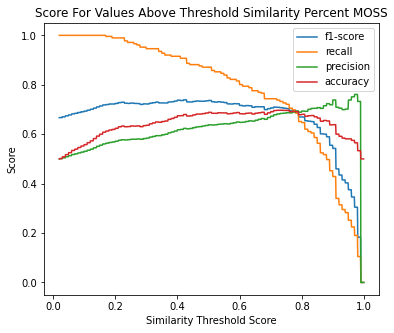

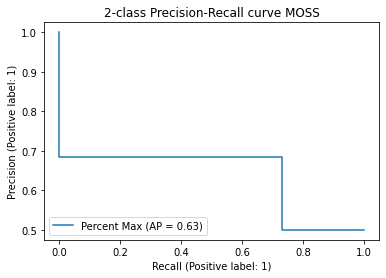

[[2413  881]
 [1115 2179]]
Max Accuracy at 0.7300000000000006 Similarity Score - Min Similarity Score 0.02
accuracy = 0.6970248937462052
precision = 0.6839569160997733
recall=0.7325440194292653
f1=0.7074171797126942


In [ ]:
# calculate average precision at level for MOSS already in the data
#
plotresults(test_df['percent']/100.0,1000,test_df, title='MOSS')

In [ ]:
# generate the sentence embeddings without the sentence transformer
# Taken generally from huggingface (https://huggingface.co/sentence-transformers/bert-base-nli-cls-token)
#
# Load model from HuggingFace Hub
def generate_embeddings(model, tokenizer, sentences):
  def cls_pooling(model_output, attention_mask):
    # max pooling
      return model_output[0][:,0]
  # Tokenize sentences
  encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

  # Compute token embeddings
  with torch.no_grad():
      model_output = model(**encoded_input)

  # Perform pooling. In this case, max pooling.
  sentence_embeddings = cls_pooling(model_output, encoded_input['attention_mask'])
  return sentence_embeddings


In [ ]:

# Generrate the similarity metrics for each model from the embeddings.
# It iterates over n token_size elements of the file to get chunks that it 
# produces embeddings for which it then averages and then does a cosine similarity
# between the file paris in the data frame df.
#
def generatesimilarity(model,df,batch_size=1,tokenizer=None, BertModel=False, token_size=100):
  def splitcode(df,token_size=256):
    #svector = df.apply(lambda x: x.split('\n') )
    svector = df.apply(lambda x: textwrap.wrap(x,token_size) )
    #print('vector len', len(svector[0]))
    return svector

  sentence_embeddings_source0 = np.empty(len(df['source0']), dtype=object)
  sentence_embeddings_source1 = np.empty(len(df['source1']), dtype=object)
  maxstrlen = max(df.source0.map(len).max(),df.source0.map(len).max())

  sourcedf0 = splitcode(df['source0'],token_size) #df['source0'].apply(lambda x: x.split('\n') )
  sourcedf0len = sourcedf0.apply(lambda x: len(x))
  sourcedf0 = np.concatenate(sourcedf0.to_numpy())

  if BertModel:
      source0 = generate_embeddings(model, tokenizer, list(sourcedf0))
  else:
    source0 = model.encode(list(sourcedf0), convert_to_tensor=True,batch_size=batch_size,show_progress_bar=True)

  sourcedf0 = np.split(source0,np.cumsum(list(sourcedf0len))[:-1])
  sentence_embeddings_source0 = sourcedf0

  sourcedf1 = splitcode(df['source1'],token_size) 
  sourcedf1len = sourcedf1.apply(lambda x: len(x))
  sourcedf1 = np.concatenate(sourcedf1.to_numpy())

  if BertModel:
    source1 = generate_embeddings(model, tokenizer, list(sourcedf1))
  else:
    source1 = model.encode(list(sourcedf1), convert_to_tensor=True,batch_size=batch_size,show_progress_bar=True)

  sourcedf1 = np.split(source1,np.cumsum(list(sourcedf1len))[:-1])
  sentence_embeddings_source1 = sourcedf1
  similarity_vector = np.array([(1 - distance.cosine(torch.mean(source0,0).cpu(),torch.mean(source1,0).cpu())) for source0,source1 in tqdm(list(zip(sentence_embeddings_source0,sentence_embeddings_source1)))])
  return similarity_vector

In [ ]:

def output_matrix(similarity_matrix):
  #cmap = cm.get_cmap('Greens')
  cmap = cm.get_cmap('YlGnBu')
  cmap = cm.get_cmap('RdYlGn')
  labels = []
  #for hood in hood_menu_data:
  #labels.append(hood["properties"]['NAME'])
  
  fig, ax = plt.subplots(figsize=(20,20))
  cax = ax.matshow(similarity_matrix, interpolation='nearest', cmap=cmap)
  ax.grid(True)
  plt.title('Similarity matrix')
  # plt.xticks(range(33), labels, rotation=90);
  # plt.yticks(range(33), labels);
  fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
  plt.show()

In [ ]:
#BERT Model both max and mean pooling
#
word_embedding_model = models.Transformer("bert-base-uncased") #'sentence-transformers/bert-base-nli-cls-token',
#word_embedding_model = models.Transformer("bert-large-uncased-whole-word-masking")#'bert-base-nli-mean-tokens')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),pooling_mode='max')
bertsentencemodel = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:
similarity1 = generatesimilarity(bertsentencemodel,test_df,batch_size=256, token_size=256, BertModel=False) 

Batches:   0%|          | 0/318 [00:00<?, ?it/s]

Batches:   0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/6588 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

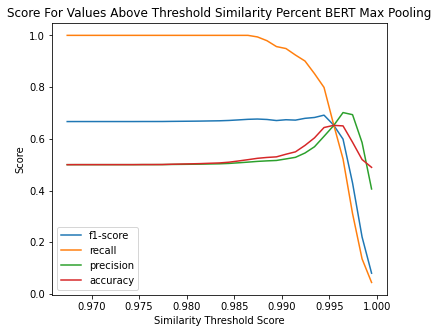

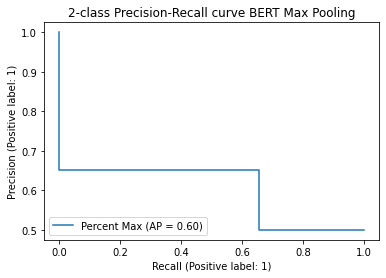

[[2163 1131]
 [1162 2132]]
Max Accuracy at 0.9954409031867981 Similarity Score - Min Similarity Score 0.9674409031867981
accuracy = 0.6519429265330905
precision = 0.6505263157894737
recall=0.656648451730419
f1=0.6535730472881099


In [ ]:
plotresults(similarity1,1000,test_df, title='BERT Max Pooling')

In [ ]:
similarity1 = None
bertsentencemodel = None
gc.collect()

5754

In [ ]:
word_embedding_model = models.Transformer("bert-base-uncased")
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),pooling_mode='mean')
bertsentencemodel = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:
similarity1 = generatesimilarity(bertsentencemodel,test_df,batch_size=256, token_size=256, BertModel=False) 

Batches:   0%|          | 0/318 [00:00<?, ?it/s]

Batches:   0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/6588 [00:00<?, ?it/s]

  0%|          | 0/297 [00:00<?, ?it/s]

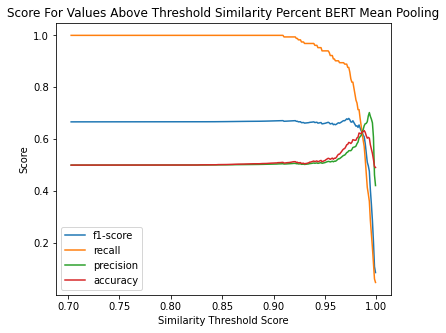

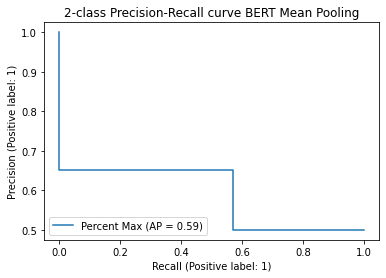

[[1884 1410]
 [1006 2288]]
Max Accuracy at 0.9880964493751528 Similarity Score - Min Similarity Score 0.7030964493751526
accuracy = 0.6332726168791742
precision = 0.6519031141868512
recall=0.5719489981785064
f1=0.6093143596377749


In [ ]:
plotresults(similarity1,1000,test_df, title='BERT Mean Pooling')

In [ ]:
similarity1 = None
bertsentencemodel = None
gc.collect()

5699

In [ ]:
#CodeBERT Model both max and mean pooling
#

word_embedding_model = models.Transformer('microsoft/codebert-base')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),pooling_mode='max')
codebertsentencemodel = SentenceTransformer(modules=[word_embedding_model, pooling_model])


Downloading:   0%|          | 0.00/498 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
similarity2 =  generatesimilarity(codebertsentencemodel,test_df,batch_size=256,token_size=256)

Batches:   0%|          | 0/318 [00:00<?, ?it/s]

Batches:   0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/6588 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

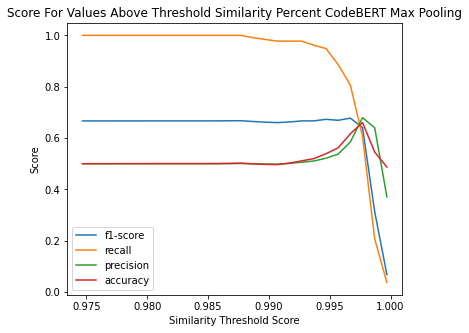

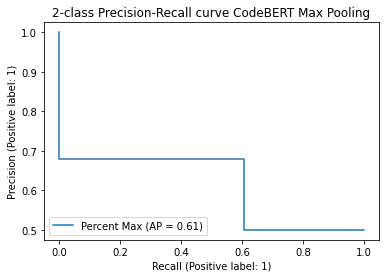

[[1998 1296]
 [ 942 2352]]
Max Accuracy at 0.9976981263160706 Similarity Score - Min Similarity Score 0.9746981263160706
accuracy = 0.6602914389799636
precision = 0.6795918367346939
recall=0.6065573770491803
f1=0.6410009624639077


In [ ]:
plotresults(similarity2,1000,test_df,title="CodeBERT Max Pooling")

In [ ]:
codebertsentencemodel = None
similarity2 = None
gc.collect()

0

In [ ]:
word_embedding_model = models.Transformer('microsoft/codebert-base')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),pooling_mode='mean')
codebertsentencemodel = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:
similarity2 =  generatesimilarity(codebertsentencemodel,test_df,batch_size=256,token_size=256)

Batches:   0%|          | 0/318 [00:00<?, ?it/s]

Batches:   0%|          | 0/324 [00:00<?, ?it/s]

  0%|          | 0/6588 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

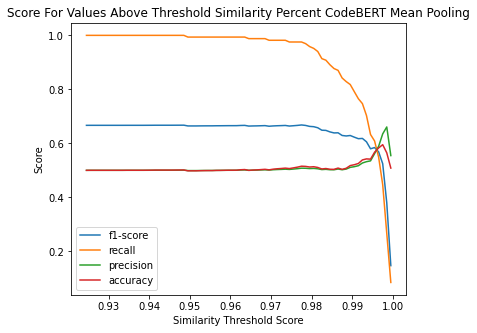

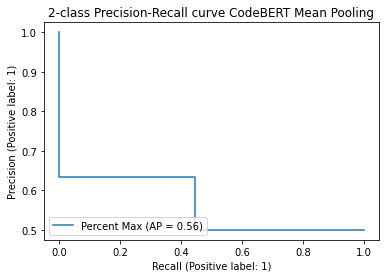

[[1472 1822]
 [ 846 2448]]
Max Accuracy at 0.997529254436493 Similarity Score - Min Similarity Score 0.9245292544364929
accuracy = 0.5950212507589556
precision = 0.635030198446937
recall=0.44687310261080754
f1=0.5245901639344261


In [ ]:
plotresults(similarity2,1000,test_df,title="CodeBERT Mean Pooling")

In [ ]:
codebertsentencemodel = None
similarity2 = None
gc.collect()

25577

In [ ]:
#LongFormer Model both max and mean pooling
#
word_embedding_model = models.Transformer('allenai/longformer-base-4096')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),pooling_mode='max')
longformersentencemodel = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:

similarity3 = generatesimilarity(longformersentencemodel,test_df,batch_size=2,token_size=2048)

Batches:   0%|          | 0/6543 [00:00<?, ?it/s]

Batches:   0%|          | 0/6713 [00:00<?, ?it/s]

  0%|          | 0/6588 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

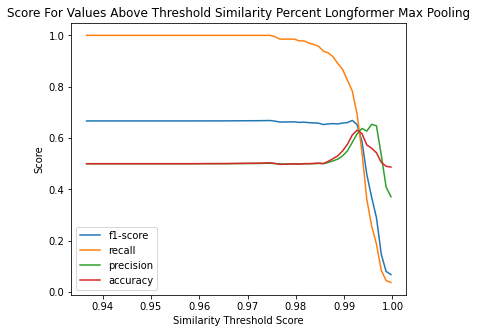

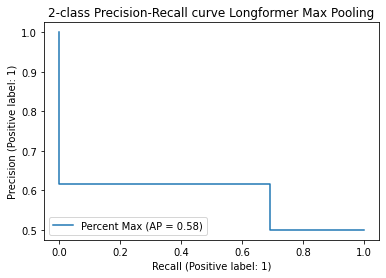

[[2280 1014]
 [1419 1875]]
Max Accuracy at 0.9926839528083802 Similarity Score - Min Similarity Score 0.9366839528083801
accuracy = 0.6306921675774135
precision = 0.616382806163828
recall=0.692167577413479
f1=0.6520806520806519


In [ ]:
plotresults(similarity3,1000,test_df,title='Longformer Max Pooling')

In [ ]:
word_embedding_model = None
pooling_model = None
longformersentencemodel =None
gc.collect()
torch.cuda.empty_cache()

In [ ]:
word_embedding_model = models.Transformer('allenai/longformer-base-4096')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),pooling_mode='mean')
longformersentencemodel = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:
similarity3 = generatesimilarity(longformersentencemodel,test_df,batch_size=2,token_size=2048)

Batches:   0%|          | 0/6543 [00:00<?, ?it/s]

Batches:   0%|          | 0/6713 [00:00<?, ?it/s]

  0%|          | 0/6588 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

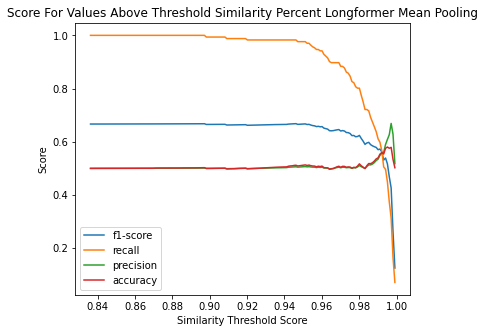

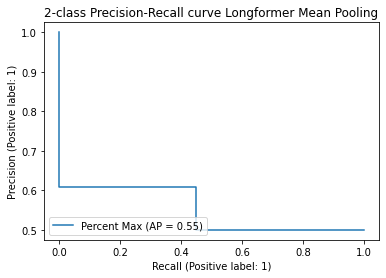

[[1480 1814]
 [ 951 2343]]
Max Accuracy at 0.9951171483993532 Similarity Score - Min Similarity Score 0.836117148399353
accuracy = 0.5802975106253795
precision = 0.6088029617441382
recall=0.4493017607771706
f1=0.5170305676855895


In [ ]:
plotresults(similarity3,1000,test_df,title='Longformer Mean Pooling')

In [ ]:
word_embedding_model = None
pooling_model = None
longformersentencemodel =None
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# T5Large Model both max and mean pooling
#
word_embedding_model = models.Transformer('sentence-transformers/sentence-t5-large')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),pooling_mode='mean')
t5largesentencemodel = SentenceTransformer(modules=[word_embedding_model, pooling_model])

#t5largesentencemodel = SentenceTransformer('sentence-transformers/sentence-t5-large')

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/639M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [ ]:
similarity4 = generatesimilarity(t5largesentencemodel,test_df,batch_size=32,token_size=2048)

Batches:   0%|          | 0/409 [00:00<?, ?it/s]

Batches:   0%|          | 0/420 [00:00<?, ?it/s]

  0%|          | 0/6588 [00:00<?, ?it/s]

  0%|          | 0/708 [00:00<?, ?it/s]

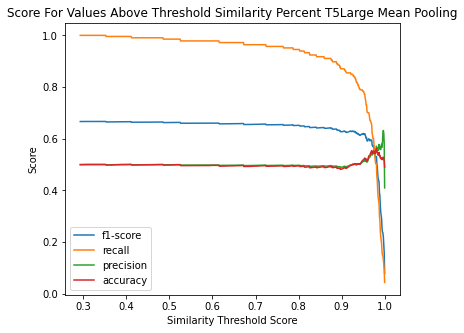

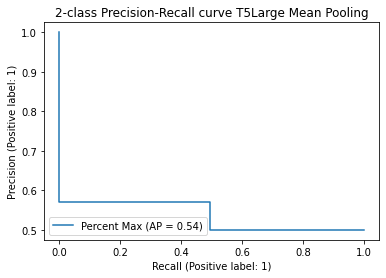

[[1636 1658]
 [1228 2066]]
Max Accuracy at 0.9809115295410162 Similarity Score - Min Similarity Score 0.2929115295410156
accuracy = 0.5619307832422586
precision = 0.5712290502793296
recall=0.49666059502125076
f1=0.5313413445924


In [ ]:
plotresults(similarity4,1000,test_df,title='T5Large Mean Pooling')

In [ ]:
t5largesentencemodel =None
similarity4 = None
gc.collect()

25656

In [ ]:
#BigBird Model both max and mean pooling
#
word_embedding_model = models.Transformer('google/bigbird-roberta-base')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),pooling_mode='mean')
bigbirdsentencemodel = SentenceTransformer(modules=[word_embedding_model, pooling_model])

#bigbirdsentencemodel = SentenceTransformer('google/bigbird-roberta-base')

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/826k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/775 [00:00<?, ?B/s]

In [ ]:
similarity6 =  generatesimilarity(bigbirdsentencemodel,test_df,batch_size=64,token_size=2048)

Batches:   0%|          | 0/205 [00:00<?, ?it/s]

Batches:   0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/6588 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

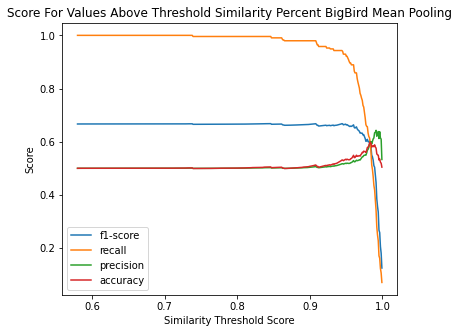

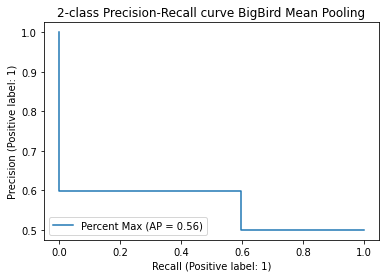

[[1963 1331]
 [1314 1980]]
Max Accuracy at 0.9831795125007633 Similarity Score - Min Similarity Score 0.5801795125007629
accuracy = 0.5985124468731026
precision = 0.599023497101007
recall=0.5959319975713419
f1=0.5974737482879319


In [ ]:
plotresults(similarity6,1000,test_df,title='BigBird Mean Pooling')

In [ ]:
word_embedding_model = None
pooling_model = None
bigbirdsentencemodel =None
similarity6=None
gc.collect()

5605